In [1]:
def normalize(X):
    for i in range(X.shape[1]):
        X[:,i] = (X[:,i] - X[:,i].mean())/X[:,i].std()
    return X

In [2]:

# from sklearn import tree
import pandas as pd
import numpy as np
def get_data():
    """
    Returns the data from the xlsx file
    """
    file_name = 'yeast.csv' 
    df = pd.read_csv(file_name, index_col=None)
    # print(df.head()) # print the first 5 rows
    return df

C = 10

D = 8
# p = 8

md = get_data()


# drop the 0 column
# ?????????
md = md.drop(columns=['DBName'])

md.dropna(inplace = True)
# print(md.shape)
md.replace('?', 0, inplace = True)

print(md.head(10))

# print(md[0 : 1])

#print(columns[1])


      1     2     3     4    5    6     7     8 OutName
0  0.58  0.61  0.47  0.13  0.5  0.0  0.48  0.22     MIT
1  0.43  0.67  0.48  0.27  0.5  0.0  0.53  0.22     MIT
2  0.64  0.62  0.49  0.15  0.5  0.0  0.53  0.22     MIT
3  0.58  0.44  0.57  0.13  0.5  0.0  0.54  0.22     NUC
4  0.42  0.44  0.48  0.54  0.5  0.0  0.48  0.22     MIT
5  0.51  0.40  0.56  0.17  0.5  0.5  0.49  0.22     CYT
6  0.50  0.54  0.48  0.65  0.5  0.0  0.53  0.22     MIT
7  0.48  0.45  0.59  0.20  0.5  0.0  0.58  0.34     NUC
8  0.55  0.50  0.66  0.36  0.5  0.0  0.49  0.22     MIT
9  0.40  0.39  0.60  0.15  0.5  0.0  0.58  0.30     CYT


Convert continuous data to categorical one

In [3]:
noOfBins = 50
# print(md['DBName'])
# print(md.columns)
# print(md['1'])
for i in range(D):
    md["cat" + str(i + 1)] = pd.cut(md[str(i+1)].values, bins=noOfBins, labels= range(0, noOfBins))
md.drop(columns=['1', '2', '3', '4', '5', '6', '7', '8'], inplace=True)
last_column = md.pop('OutName')
md.insert(8, 'OutName', last_column)
md.head(20)
# gk = md.groupby('Outname')
# print(md[1].value_counts())


,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,OutName
0,26,27,16,6,0,0,32,10,MIT
1,17,31,17,13,0,0,36,10,MIT
2,29,28,17,7,0,0,36,10,MIT
3,26,17,22,6,0,0,36,10,NUC
4,17,17,17,26,0,0,32,10,MIT
5,22,15,22,8,0,30,33,10,CYT
6,21,23,17,32,0,0,36,10,MIT
7,20,18,24,9,0,0,39,16,NUC
8,24,21,28,17,0,0,33,10,MIT
9,16,14,24,7,0,0,39,14,CYT


In [4]:
X = md.iloc[:, 0:8].values.reshape(-1, 8)

outputs = ['CYT', 'NUC', 'MIT', 'ME3', 'ME2', 'ME1', 'EXC', 'VAC', 'POX', 'ERL']

# outputs = ['CYT', 'ERL', 'EXC', 'ME1', 'ME2', 'ME3', 'MIT', 'NUC', 'POX', 'VAC']

M = X.shape[0]
Y = md.iloc[:, 8:9].values.reshape(-1, 1)

In [5]:
y = np.zeros(len(Y))

for i in range(len(Y)):
    y[i] = outputs.index(Y[i][0])


In [6]:
def calculatePiAndTheta(md, X, y, C, alpha):
    ncValues = np.zeros(C)
    piValues = []

    testSize = len(X)

    # calculate the pi values
    for i in range(testSize):
        ncValues[int(y[i])] += 1
    for c in range(C):
        piValues.append(ncValues[c]/testSize)

    # print(sum(piValues))

    # calculate theta values
    md[['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8']] = md[['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8']].astype(int)

    data_mod = md.groupby(['OutName']).sum()

    # arrange colums w.r.t. hardcoded output array
    data_mod.unstack()
    data_mod_t = data_mod.transpose()
    data_mod_t = data_mod_t[outputs]
    data_mod = data_mod_t.transpose()

    axisSum = data_mod.sum(axis=1)

    theta = []

    # smoothing parameter


    for d in range(D):
        theta.append((data_mod['cat' + str(d + 1)] + alpha )/ (axisSum + alpha*D))

    return piValues, theta
alpha = 0.001
piValues, theta = calculatePiAndTheta(md, X, y, C, alpha)


accuracy:  0.5700808625336927


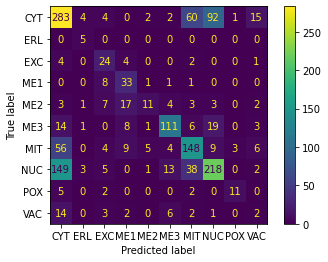

'              precision    recall  f1-score   support\n\n         CYT       0.54      0.61      0.57       463\n         ERL       0.36      1.00      0.53         5\n         EXC       0.42      0.69      0.52        35\n         ME1       0.45      0.75      0.56        44\n         ME2       0.52      0.22      0.31        51\n         ME3       0.79      0.68      0.73       163\n         MIT       0.56      0.61      0.58       244\n         NUC       0.64      0.51      0.57       429\n         POX       0.73      0.55      0.63        20\n         VAC       0.06      0.07      0.07        30\n\n    accuracy                           0.57      1484\n   macro avg       0.51      0.57      0.51      1484\nweighted avg       0.58      0.57      0.57      1484\n'

In [7]:

def predict(testSet, testValues, piValues, theta, C, D):
    # testSet = X
    prediction = np.zeros(len(testSet))

    for i in range(len(testSet)): 
        prbAllClass = np.zeros(C)
        for c in range(C):
            prbAllClass[c] = np.log(piValues[c])
            for d in range(D):
                first = testSet[i][d]
                
                # first = np.log(1 + md_dic['cat' + str(d + 1)][i])
                second = np.log(theta[d][c]) # ['cat' + str(d + 1)][outputs[c]])
                
                prbAllClass[c] += first * second

        # print(prbAllClass)
        prediction[i] = np.argmax(prbAllClass)
        # print(prediction[i], testValues[i])

    # print("accuracy: ", (prediction == testValues[:len(testSet)]).sum()/len(testSet))
    return prediction, (prediction == testValues[:len(testSet)]).sum(), len(testSet)




result = predict(X, y, piValues, theta, C, D)
print("accuracy: ", result[1] / result[2])

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred_list = []
y_pred = result[0]

for i in range(M):
    # print(outputs[int(y_pred[i])], end=' ')
    y_pred_list.append(outputs[int(y_pred[i])])
ConfusionMatrixDisplay.from_predictions(Y, y_pred_list)
plt.show()

from sklearn.metrics import classification_report
classification_report(Y, y_pred_list, zero_division=1)

In [8]:
# test for different alpha values 
# apply cross one out validation to compute accuracy

# alphaValues = [0.001, 0.01, 0.05, 0.1, 1, 2, 5, 10, 100]
alphaValues = [0.01]

for alpha in alphaValues:
    print(alpha)
    correct = 0
    for i in range(M):

        data = md.drop(axis=0, index=i)
        # print(data.index)

        cutted = md.iloc[i]

        y_test = outputs.index(md.iloc[i]['OutName'])
        y_test = np.array( [y_test] )

        x_test = np.zeros((1, D))
        for d in range(D):
            x_test[0][d] = cutted['cat' + str(d + 1)]

        X = data.iloc[:, 0:8].values.reshape(-1, 8)
        Y = data.iloc[:, 8:9].values.reshape(-1, 1)

        y = np.zeros(len(Y))
        for i in range(len(Y)):
            y[i] = outputs.index(Y[i][0])

        piValues, theta = calculatePiAndTheta(data, X, y, C, alpha)
        res = predict(x_test, y_test, piValues, theta, C, D)
        

        correct += res[1]

    print("accuracy: ", correct/M)

0.01
accuracy:  0.5660377358490566


In [9]:
# from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import ComplementNB

# X_train, X_test, Y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# gnb = ComplementNB()
# gnb.fit(X_train, Y_train)
# y_pred = gnb.predict(X_test)
# print("Number of mislabeled points out of a total %d points : %d"
#       % (X_test.shape[0], (y_test != y_pred).sum()))

# from sklearn import metrics

# # Model Accuracy, how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

gnb = MultinomialNB()
gnb.fit(X_train, Y_train)

# X_test = X[:50]
y_pred = gnb.predict(X_test)
# y_test = y[:50]


print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))



from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Number of mislabeled points out of a total 594 points : 257
Accuracy: 0.5673400673400674
